** Ongoing develpment of fact extraction methods **
** Certain reports were not being generated by the refactored code in the previous version. - Need to evaluate content as well as quantity of reports.**
**This is very much a work in progress.**

In [24]:
import pandas as pd
import spacy
import os
import sys
from nltk import Tree
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from internal_displacement.pipeline import SQLArticleInterface

In [25]:
nlp = spacy.load('en')

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [26]:
pipeline = SQLArticleInterface("../sql_db.sqlite") #Connecting to pre-populated database.
labels,features = pipeline.get_training_data()

In [27]:
person_reporting_terms = [
    'displaced', 'evacuated', 'forced','flee', 'homeless', 'relief camp',
    'sheltered', 'relocated', 'stranded','stuck','stranded',"killed","dead","died"
]

structure_reporting_terms = [
    'destroyed','damaged','swept','collapsed','flooded','washed'
]

person_reporting_units = ["families","person","people","individuals","locals","villagers","residents","occupants","citizens"]

structure_reporting_units = ["home","house","hut","dwelling","building","shop","business","apartment","flat","residence"]


person_term_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_terms))]
structure_term_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_terms))]
person_unit_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_units))]
structure_unit_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_units))]

reporting_term_lemmas = person_term_lemmas + structure_term_lemmas
reporting_unit_lemmas = person_unit_lemmas + structure_unit_lemmas

In [31]:
class Report:
    def __init__(self,locations,date_times,event_term,subject_term,quantity,story):
        self.locations = locations
        if date_times:
            self.date_times = [date.text for date in date_times]
        else:
            self.date_times = []
        self.event_term = [t.lemma_ for t in nlp(event_term)][0]
        self.subject_term = subject_term
        self.quantity = quantity
        self.story = story
    
    def display(self):
        print("Location: {}  DateTime: {}  EventTerm: {}  SubjectTerm:  {}  Quantity: {}"
              .format(self.locations,self.date_times,self.event_term,self.subject_term,self.quantity))
        
    def show_story_tree(self):
        self.display()
        for sentence in nlp(self.story).sents:
            for token in sentence:
                if token.lemma_ == self.event_term:
                    return to_nltk_tree(sentence.root)
    def __eq__(self, other):
        if isinstance(other, Item):
            return ((self.foo == other.foo) and (self.bar == other.bar))
        else:
            return False
    def __ne__(self, other):
        return (not self.__eq__(other))
    def __hash__(self):
        return hash(self.__repr__())

In [34]:
def test_token_equality(token_a,token_b):
    if token_a.text == token_b.text:
        return True
    else:
        return False
    
def check_if_collection_contains_token(token,collection):
    if any([test_token_equality(token,t) for t in collection]):
        return True
    else:
        return False

def get_descendents(sentence,root=None):
    """
    Retrieves all tokens that are descended from the specified root token.
    param: root: the root token
    param: sentence: a span from which to retrieve tokens.
    returns: a list of tokens
    """
    if not root:
        root = sentence.root
    return [t for t in sentence if root.is_ancestor_of(t)]

def get_head_descendents(sentence,root=None):
    """
    Retrieves all tokens that are descended from the head of the specified root token.
    param: root: the root token
    param: sentence: a span from which to retrieve tokens.
    returns: a list of tokens
    """
    if not root:
        root = sentence.root
    else:
        root = root.head
    return [t for t in sentence if root.is_ancestor_of(t)]
    
def check_if_entity_contains_token(tokens,entity):
    """
    Function to test if a given entity contains at least one of a list of tokens.
    param: tokens: A list of tokens
    param: entity: A span
    
    returns: Boolean
    """
    tokens_ = [t.text for t in tokens]
    ret = False
    for token in entity:
        if token.text in tokens_:
            return True
    return False
    

def get_distance_from_root(token,root):
    """
    Gets the parse tree distance between a token and the sentence root.
    :param token: a token
    :param root: the root token of the sentence
    
    returns: an integer distance
    """
    if token == root:
        return 0
    d = 1
    p = token.head
    while p is not root:
        d+=1
        p = p.head
    return d




def get_common_ancestors(tokens):
    ancestors = [set(t.ancestors) for t in tokens]
    if len(ancestors) == 0:
        return []
    common_ancestors = ancestors[0].intersection(*ancestors)
    return common_ancestors    


def get_distance_between_tokens(token_a,token_b):

    if token_b in token_a.subtree:
        distance = get_distance_from_root(token_b,token_a)
    elif token_a in token_b.subtree:
        distance = get_distance_from_root(token_a,token_b)
    else:
        common_ancestors = get_common_ancestors([token_a,token_b])
        distance = 10000
        for ca in common_ancestors:
            distance_a = get_distance_from_root(ca,token_a)
            distance_b = get_distance_from_root(ca,token_b)
            distance_ab = distance_a + distance_b
            if distance_ab < distance:
                distance = distance_ab
    return distance


def get_closest_contiguous_location_block(entity_list,root_node):
    location_entity_tokens = [[token for token in sentence] for sentence in entity_list]
    token_list =  [item for sublist in location_entity_tokens for item in sublist]
    location_tokens_by_distance = sorted([(token,get_distance_between_tokens(token,root_node)) 
                                          for token in token_list],key= lambda x: x[1])
    closest_location = location_tokens_by_distance[0]
    contiguous_block = [closest_token]
    added_tokens = 1
    while added_tokens > 0:
        contiguous_block_ancestors = [[token for token in token_list if token.is_ancestor_of(toke)] for toke in contiguous_block ]
        contiguous_block_subtrees = [token.subtree for token in contiguous_block]
        contiguous_block_neighbours = contiguous_block_ancestors + contiguous_block_subtrees
        contiguous_block_neighbours = [item for sublist in contiguous_block_neighbours for item in sublist]
        added_tokens = 0
        for toke in token_list:
            if not check_if_collection_contains_token(toke,contiguous_block):
                if toke in contiguous_block_neighbours:
                    added_tokens +=1
                    contiguous_block.append(toke)
    return contiguous_block



def get_contiguous_tokens(token_list):
    common_ancestor_tokens = get_common_ancestors(token_list)
    highest_contiguous_block = []
    for toke in token_list:
        if check_if_collection_contains_token(toke.head,common_ancestor_tokens):
            highest_contiguous_block.append(toke)
    added_tokens = 1
    while added_tokens > 0:
        added_tokens = 0
        for toke in token_list:
            if check_if_collection_contains_token(toke.head,highest_contiguous_block):
                if not check_if_collection_contains_token(toke,highest_contiguous_block):
                    highest_contiguous_block.append(toke)
                    added_tokens +=1
    return highest_contiguous_block

def match_entities_in_block(entities,token_block):
    matched = []
    text_block = [t.text for t in token_block] #For some reason comparing identity on tokens does not always work.
    for e in entities:
        et = [t.text for t in e]
        et_in_b = [t for t in et if t in text_block]
        if len(et_in_b) == len(et):
            matched.append(e)
    return matched

def extract_locations(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a location.
    If a root token is specified, only location tokens below the level of this token in the tree will be examined. 
    If no root is specified, location tokens will be drawn from the entirety of the span.
    param: sentence       a span
    param: root           a token
    returns: A list of strings, or None
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root)
    location_entities = [e for e in nlp(sentence.text).ents if e.label_ == "GPE"]
    if len(location_entities) > 0:
        descendent_location_tokens = []
        for location_ent in location_entities:
            if check_if_entity_contains_token(location_ent,descendents):
                descendent_location_tokens.extend([token for token in location_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_location_tokens)

        block_locations = match_entities_in_block(location_entities,contiguous_token_block)
        if len(block_locations) > 0:
            return [location.text for location in block_locations]
        else:
            return location_entities #If we cannot decide which one is correct, choose them all
                                    #and figure it out at the report merging stage.
    else:
        return []
def extract_dates(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a date.
    If a root token is specified, only date tokens below the level of this token in the tree will be examined. 
    If no root is specified, date tokens will be drawn from the entirety of the span.
    Unlike the extract dates function (which returns a list of strings),
    this function returns a list of spacy spans. This is because numerical quantities detected in the 
    branch_search need to be checked to ensure they are not in fact parts of a date.
    
    param: sentence       a span
    param: root           a token
    returns: A list of spacy spans
    """
    if not root:
        root = sentence.root
    descendents = get_head_descendents(sentence,root)
    date_entities = [e for e in nlp(sentence.text).ents if e.label_ == "DATE"]
    if len(date_entities) > 0:
        descendent_date_tokens = []
        for date_ent in date_entities:
            if check_if_entity_contains_token(date_ent,descendents):
                descendent_date_tokens.extend([token for token in date_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_date_tokens)

        block_dates = match_entities_in_block(date_entities,contiguous_token_block)
        return block_dates
    else:
        return None

    
def check_not_in_date(token,date_entities):
    """
    Checks if a token is not part of a recognised date entity.
    :param token     a token
    :param date_tokens    the list of spacy date entities produced by extract_dates
    
    returns: boolean
    """
    if date_entities:
        for date in date_entities:
            if token in date:
                return False
    return True
  
def basic_number(token):
    if token.text == "dozens":
        return True
    if token.like_num:
        return True
    else:
        return False
        
    
def branch_search(root_node,search_target_lemmas,root_type,dates_memory,locations_memory,story,sentence,unit_type):
    """
    Attempts to complete a report starting from the specified root node
    """
    descendents = get_head_descendents(sentence,root_node)
    relevant_descendents = [t for t in descendents if t.lemma_ in search_target_lemmas]
    
    possible_locations = extract_locations(sentence,root_node)
    possible_dates = extract_dates(sentence,root_node)
    if not possible_locations:
        possible_locations = locations_memory
    if not possible_dates:
        possible_dates = dates_memory

    reports = []

    if root_type == "TERM":
        report_term = root_node.lemma_
        numeric_descendents = [t for t in get_descendents(sentence,root_node) if basic_number(t)] #Extract numerics here to allow for implicit units
        if len(numeric_descendents) == 0:
            numeric_descendents =  [t for t in get_head_descendents(sentence,root_node) if basic_number(t)]
        for unit_child in relevant_descendents:
            report_unit = unit_child
            report_unit_descendents = get_descendents(sentence,report_unit)
            for rud in report_unit_descendents:
                if basic_number(rud) and check_not_in_date(rud,possible_dates):
                    report_quantity = rud.text
                    report = Report(possible_locations,possible_dates,report_term,
                                    report_unit.lemma_,report_quantity,story)
                    reports.append(report)
                    report.show_story_tree()
                    break #operating on the assumption that the closest number to the term is the most relevant one.
            if len(report_unit_descendents) == 0:
                report_unit_descendents = get_head_descendents(sentence,report_unit)
                for rud in report_unit_descendents:
                    if basic_number(rud) and check_not_in_date(rud,possible_dates):
                        report_quantity = rud.text
                        report = Report(possible_locations,possible_dates,report_term,
                                        report_unit.lemma_,report_quantity,story)
                        reports.append(report)
                        report.show_story_tree()
                        break #operating on the assumption that the closest number to the term is the most relevant one.
                
        if unit_type == "PERSON": #Checking for implicits
            if len(relevant_descendents) == 0:
                    for number in numeric_descendents:
                        if check_not_in_date(number,possible_dates):
                            report_unit = "Person"
                            report = Report(possible_locations,possible_dates,report_term,
                                    report_unit,number,story)
                            reports.append(report)
                            report.show_story_tree()
                            break


            
    elif root_type == "UNIT":
        report_unit = root_node.lemma_
        for term_child in relevant_descendents:
            report_term = term_child
            report_term_descendents = get_descendents(sentence,report_term)
            for rtd in report_term_descendents:
                if rtd.like_num and check_not_in_date(rtd,possible_dates):
                    report_quantity = rtd.text
                    report = Report(possible_locations,possible_dates,report_term.lemma_,
                                    report_unit,report_quantity,story)
                    reports.append(report)
                    report.show_story_tree()
                    break #operating on the assumption that the closest number to the term is the relevant one.
    return reports
    
    
def process_sentence(sentence,dates_memory,locations_memory,story):
    """
    Searches for a starting point to begin creating a report. 
    This can be either a reporting term or a reporting unit.
    Always searches top-down.
    """
    sentence_reports = []
    for token in sentence:
        reports = []
        if token.lemma_ in structure_term_lemmas:
            root_type = "TERM"
            unit_type = "STRUCTURE"
            targets = structure_unit_lemmas
            reports = branch_search(token,targets,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        elif token.lemma_ in structure_unit_lemmas:
            root_type = "UNIT"
            unit_type = "STRUCTURE"
            targets = structure_term_lemmas
            reports = branch_search(token,targets,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        elif token.lemma_ in person_term_lemmas:
            root_type = "TERM"
            unit_type = "PERSON"
            targets = person_unit_lemmas
            reports = branch_search(token,targets,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        elif token.lemma_ in person_unit_lemmas:
            root_type = "UNIT"
            unit_type = "PERSON"
            targets = person_term_lemmas
            reports = branch_search(token,targets,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        sentence_reports.extend(reports)
    return list(set(sentence_reports))
        
def process_article(story):
    processed_reports = []
    if len(story) < 25:
        return processed_reports
    
    sentences = list(nlp(story).sents) # Split into sentences
    dates_memory = None # Keep a running track of the most recent dates found in articles
    locations_memory = None # Keep a running track of the most recent locations found in articles
    for sentence in sentences: # Process sentence
        reports = []
        reports = process_sentence(sentence,dates_memory,locations_memory, story)
        current_locations = extract_locations(sentence)
        if current_locations:
            locations_memory = current_locations
        current_dates = extract_dates(sentence)
        if current_dates:
            dates_memory = current_dates
        processed_reports.extend(reports)
    return processed_reports

In [35]:
reports = []
for article in features[:100]:
    print("ARTICLE:")
    print(article)
    print("REPORTS")
    reports.append(process_article(article))

ARTICLE:
Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals asking for assistance, but

Location: ['Baghlan Province']  DateTime: []  EventTerm: kill  SubjectTerm:  person  Quantity: 1


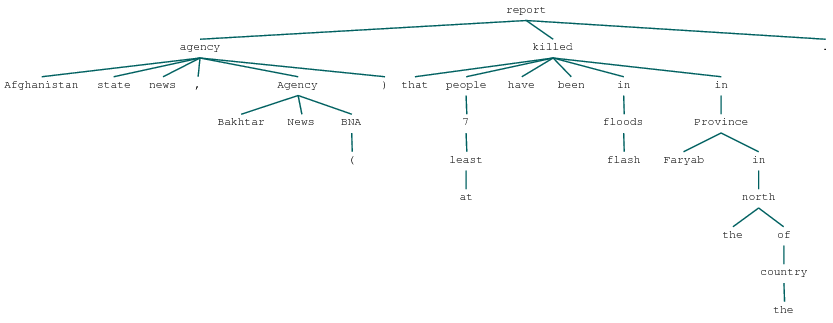

In [36]:
reports[4][1].show_story_tree()